<a href="https://colab.research.google.com/github/vshiv667/Sentiment-Analysis/blob/master/Sentiment_Analysis_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


# Import Dataset

In [0]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0
corpus = [] #list to store our corpus

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader: 
        list_item=[]
        list_item.append(row[5]) # 1st item in list_item is the text found in index [5];
        if row[0]=='0':  # 2nd item is the label. 0 if the first item of the row is '0'. Otherwise,'1'
          list_item.append(0)
        else:
          list_item.append(1)
        
        num_sentences = num_sentences + 1 #counter
        corpus.append(list_item) #list of lists: corpus[[list_item],[list_item],...]


--2020-06-10 22:26:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  50.6MB/s    in 4.5s    

2020-06-10 22:26:58 (50.6 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [0]:
print(num_sentences)
print(len(corpus))
print(corpus[1])


1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


# Padding

In [0]:
embedding_dim = 100 #embedding dimensions, GloVe 100-D used here
max_length = 16     #set max input length
trunc_type='post'   #trunc type
padding_type='post' #padding type
oov_tok = "<OOV>"
training_size= 1600000  # 1.6 million tweets
test_portion=.1         # used as validation set



sentences=[] #list to store tweets
labels=[] #list to store labels
random.shuffle(corpus)

for x in range(training_size):
    sentences.append(corpus[x][0]) #text part of inner list
    labels.append(corpus[x][1])    #label part


tokenizer = Tokenizer()           #tokenizer object
tokenizer.fit_on_texts(sentences) #create a word->index dictionary, each word gets an unique integer index

word_index = tokenizer.word_index  #get the word->index dictionary 
vocab_size=len(word_index)+1       #get length of dictionary

sequences = tokenizer.texts_to_sequences(sentences) #replace words with their indexes to feed into network
padded = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type) #add padding to ensure all sequences have same length

split = int(test_portion * training_size) #return number of int, default is float: xx.0

#specify train and test instances
test_sequences = padded[0:split]
training_sequences = padded[split:]
test_labels = labels[0:split] 
training_labels = labels[split:]

In [0]:
print(vocab_size)
print(word_index['hi'])
print(word_index['india'])


690961
307
2718


# Use GloVe 100-D

In [0]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {}; #dictionary to store GloVe 100-D 
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0]; #first value is our word
        coefs = np.asarray(values[1:], dtype='float32'); #rest 100 values are coefs for that word based on GloVe
        embeddings_index[word] = coefs; #store in a dictionary

embeddings_matrix = np.zeros((vocab_size, embedding_dim)); #create a 138319 x 100 array with zeros
for word, i in word_index.items(): 
    embedding_vector = embeddings_index.get(word); #for every word in our corpus get corresponding word index (indexes) from GloVe
    if embedding_vector is not None: #if word index (indexes) exists (i.e. word is present in both) then, 
        embeddings_matrix[i] = embedding_vector;                #store GloVe word index (indexes) at its current corpus word index (i.e. corresponding matrix(2D array) row no.)

--2020-06-10 22:28:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  63.2MB/s    in 5.2s    

2020-06-10 22:28:24 (63.2 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
print(len(embeddings_matrix))


690961


# Convolutional Neural Network using LSTM 

In [0]:
#convert to numpy array
training_labels = np.asarray(training_labels)
test_labels = np.asarray(test_labels)
training_sequences = np.asarray(training_sequences)
test_sequences= np.asarray(test_sequences)

model = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False), #use GloVe 100-D weights
    # Dropout of 20%
    tf.keras.layers.Dropout(0.2),
    # Conv1D layer
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # MaxPooling1D with size 4
    tf.keras.layers.MaxPooling1D(4),
    # LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)), 
    # Output Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile( optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'] ) 

model.summary() #view summary


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           69096100  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 64)             24832     
_________________________________________________________________
dense (Dense)                (None, 3, 1)              65        
Total params: 69,153,061
Trainable params: 56,961
Non-trainable params: 69,096,100
_______________________________________

# Fit Model

In [0]:
#fit model
num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Epoch 1/10
45000/45000 - 220s - loss: 0.5207 - accuracy: 0.7368 - val_loss: 0.4858 - val_accuracy: 0.7616
Epoch 2/10
45000/45000 - 217s - loss: 0.4954 - accuracy: 0.7551 - val_loss: 0.4761 - val_accuracy: 0.7694
Epoch 3/10
45000/45000 - 219s - loss: 0.4888 - accuracy: 0.7598 - val_loss: 0.4734 - val_accuracy: 0.7701
Epoch 4/10
45000/45000 - 216s - loss: 0.4853 - accuracy: 0.7625 - val_loss: 0.4703 - val_accuracy: 0.7723
Epoch 5/10
45000/45000 - 216s - loss: 0.4832 - accuracy: 0.7637 - val_loss: 0.4696 - val_accuracy: 0.7731
Epoch 6/10
45000/45000 - 216s - loss: 0.4813 - accuracy: 0.7651 - val_loss: 0.4684 - val_accuracy: 0.7744
Epoch 7/10
45000/45000 - 215s - loss: 0.4808 - accuracy: 0.7657 - val_loss: 0.4673 - val_accuracy: 0.7754
Epoch 8/10
45000/45000 - 214s - loss: 0.4798 - accuracy: 0.7661 - val_loss: 0.4664 - val_accuracy: 0.7754
Epoch 9/10
45000/45000 - 213s - loss: 0.4792 - accuracy: 0.7667 - val_loss: 0.4662 - val_accuracy: 0.7759
Epoch 10/10
45000/45000 - 213s - loss: 0.4782 

# Visualize metrics

<Figure size 432x288 with 0 Axes>

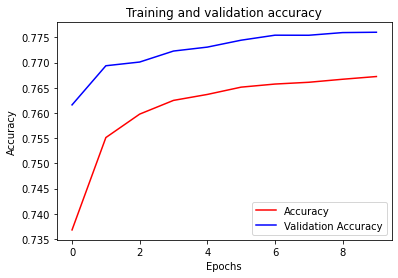

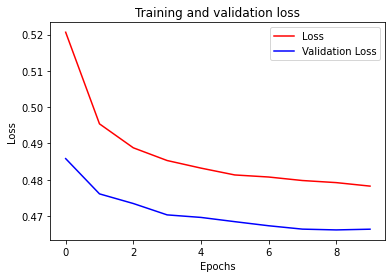

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
